In [31]:
import utils.Encryption as cen
import utils.CustomModel as cm
import utils.DataPipeline as dp
import tensorflow as tf
from PIL import Image
import json
import cv2 
import numpy as np
import matplotlib.pyplot as plt

In [32]:
root_dir = "F:\\pps_paper\\dataset"
train_dir = f"{root_dir}\\train"
test_dir = f"{root_dir}\\test"
validation_dir = f"{root_dir}\\validation"

# For Encrypted dataset
train_images = f"{root_dir}\\train\\DataPE"
train_masks = f"{root_dir}\\train\\GroundTruth_1PE"
test_images = f"{root_dir}\\test\\DataPE"
test_masks = f"{root_dir}\\test\\GroundTruth_1PE"
validation_images = f"{root_dir}\\validation\\DataPE"
validation_masks = f"{root_dir}\\validation\\GroundTruth_1PE"

# # For preprocessed dataset
# train_images = f"{root_dir}\\train\\DataP"
# train_masks = f"{root_dir}\\train\\GroundTruth_1P"
# test_images = f"{root_dir}\\test\\DataP"
# test_masks = f"{root_dir}\\test\\GroundTruth_1P"
# validation_images = f"{root_dir}\\validation\\DataP"
# validation_masks = f"{root_dir}\\validation\\GroundTruth_1P"

In [33]:
train = dp.CustomDataset(train_dir,input_dir='DataPE', mask_dir='GroundTruth_1PE').get_Dataset()
test = dp.CustomDataset(test_dir,input_dir='DataPE', mask_dir='GroundTruth_1PE').get_Dataset()
validation = dp.CustomDataset(validation_dir,input_dir='DataPE', mask_dir='GroundTruth_1PE').get_Dataset()

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
model = cm.CustomModel((256,256,3,))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
save_jc = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/',
    monitor='Specificity',
    save_weights_only = True
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=optimizer,
    metrics=
        [cm.DiceIndex(),
        cm.JaccardIndex(),
        cm.Sensitvity(),
        cm.Specificity(),
        cm.Accuracy(),],
    
    )

In [36]:
history = model.fit(train, validation_data=validation,batch_size=10,epochs=10,workers=2,validation_freq=2,callbacks=[save_jc],)

Epoch 1/10
2000/2000 [==============================] - 65s 31ms/step - loss: 0.1134 - Dice Index: 0.3310 - Jaccard Index: 0.2602 - Sensitivity: 0.2994 - Specificity: 0.9905 - Accuracy: 0.8413
Epoch 2/10
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0710 - Dice Index: 0.7012 - Jaccard Index: 0.5936 - Sensitivity: 0.7264 - Specificity: 0.9724 - Accuracy: 0.9110 - val_loss: 0.0766 - val_Dice Index: 0.6711 - val_Jaccard Index: 0.5528 - val_Sensitivity: 0.7821 - val_Specificity: 0.9568 - val_Accuracy: 0.8996
Epoch 3/10
2000/2000 [==============================] - 61s 31ms/step - loss: 0.0618 - Dice Index: 0.7333 - Jaccard Index: 0.6291 - Sensitivity: 0.7725 - Specificity: 0.9740 - Accuracy: 0.9206
Epoch 4/10
2000/2000 [==============================] - 88s 44ms/step - loss: 0.0585 - Dice Index: 0.7428 - Jaccard Index: 0.6383 - Sensitivity: 0.7879 - Specificity: 0.9747 - Accuracy: 0.9245 - val_loss: 0.0730 - val_Dice Index: 0.6703 - val_Jaccard Index: 0.5679 - val_Sen

In [37]:
history.model.summary()

Model: "custom_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(10, 256, 256, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  608       
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                  1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_9 (Conv2D)            multiple               

In [ ]:
image_name = 'ISIC_0000376' 
img = cv2.imread(f'{train_images}\\{image_name}.jpg',1)
groundTruth = cv2.imread(f'{train_masks}\\{image_name}_segmentation.png',0)
key = None
with open('key.json','r') as fp:
    key = json.load(fp)

Zb , Zg , Zr = cv2.split(img)
Zb , Zg , Zr = Zb.flatten() , Zg.flatten() , Zr.flatten()  
# convert to np.float32
Zr = np.float32(Zr)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2

ret,label,center = cv2.kmeans(Zr,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
red = center[label.flatten()]
red = red.reshape((img.shape[0],img.shape[1]))

red = cen.unscramble(red,key)


# convert to np.float32
Zg = np.float32(Zg)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center = cv2.kmeans(Zg,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
green = center[label.flatten()]
green = green.reshape((img.shape[0],img.shape[1]))

green = cen.unscramble(green,key)


# convert to np.float32
Zb = np.float32(Zb)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center = cv2.kmeans(Zb,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
blue = center[label.flatten()]
blue = blue.reshape((img.shape[0],img.shape[1]))

blue = cen.unscramble(blue,key)


img = img[...,::-1]
groundTruth = cen.unscramble(groundTruth,key)



plt.figure()

fig , ax = plt.subplots(1,5,sharey=True,figsize = (12,3))
ax[0].imshow(img)
ax[0].set_title('Encrypted Image')
ax[1].imshow(red,cmap='gray')
ax[1].set_title('Red channel')
ax[2].imshow(green,cmap='gray')
ax[2].set_title('Green channel')
ax[3].imshow(blue,cmap='gray')
ax[3].set_title('Blue channel')
ax[4].imshow(groundTruth,cmap='gray')
ax[4].set_title('GroundTruth')

plt.show()


Let's try plotting the predictions of our model

In [97]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

z = None
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    x = tf.keras.utils.array_to_img(display_list[i])
    x = np.array(x)
    # x = cen.unscramble(x,key)
    plt.imshow(x, cmap = None if i == 0 else 'gray')
    plt.axis('off')
  plt.show()

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      z = pred_mask
      display([image[0], mask[0], pred_mask[0]])

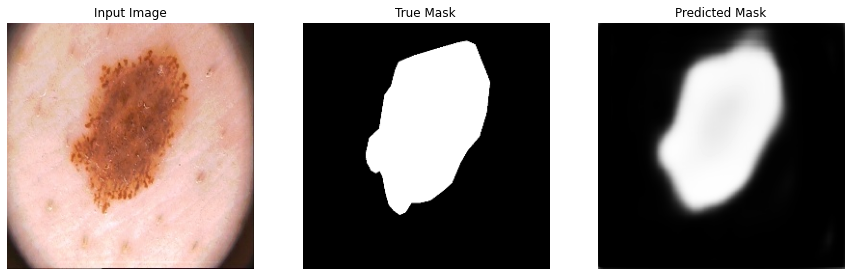

In [98]:
show_predictions(train)